# Plotting Cloud Size Number Distributions

## Libs Sections 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context('talk')
import cartopy.crs as ccrs
import cartopy.feature as cf


import glob

import tobac
import sys
import json




## Arguments

In [2]:
if 'launcher' in sys.argv[0]:
    config_file = '../scripts/config/config_precip500.json'
    date = '202006'
    interactive = True
else:
    config_file = sys.argv[1]
    date = sys.argv[2]
    interactive = False

## Configuration

In [3]:
with open(config_file, "r") as fp:
    conf = json.load(fp)
globals().update(conf)

## Input Data 

In [4]:
main_dir = "/work/bb1376/user/fabian/data/oxford-hackathon"
subname = f"{vname}_features_thresh{threshold}"

input_dir = f"/{main_dir}/{model}/{experiment}/{subname}"
infile = f'{input_dir}/monthly_{subname}_{date}.nc'

tracks = xr.open_dataset( infile )

In [5]:
tracks['ones'] = xr.ones_like( tracks['total'] )

In [6]:
tracks['diameter'] = 2*np.sqrt( tracks['area'] / np.pi )

In [7]:
tracks['diameter'].min(), tracks['diameter'].max()


(<xarray.DataArray 'diameter' ()> Size: 8B
 array(3299.34103506),
 <xarray.DataArray 'diameter' ()> Size: 8B
 array(133581.27820736))

In [8]:
tracks = tracks.set_coords('time')

## Binning

### Total CNSD

In [9]:
dmin = 20e3
dmax = 200e3
diameter_bins = np.logspace(np.log10(dmin), np.log10(dmax))
mdia = 0.5 * (diameter_bins[1:] + diameter_bins[:-1])

In [10]:
# Create a 2D histogram (count) of occurrences
counts, _ = np.histogram( tracks['diameter'], bins=diameter_bins )

In [11]:
counts

dlogD = np.diff(np.log(diameter_bins))[0]

PDF = counts / (counts.sum() * dlogD)

## Daily CNSD

In [12]:
tracks.groupby('time.day')

<DatasetGroupBy, grouped over 1 grouper(s), 30 groups in total:
    'day': 30/30 groups present with labels 1, 2, 3, 4, 5, 6, ..., 26, 27, 28, 29, 30>

In [13]:
clist = []
n = 0
for time, tr in tracks.groupby('time.day'):
    counts, _ = np.histogram( tr['diameter'], bins=diameter_bins )
    cset = xr.DataArray(counts.reshape(-1,1), coords=[diameter_bins[:-1], [time,]], dims=['diameter', 'day'])
    
    clist +=[ cset,]
    n += 1

    if n > 10:
        break

In [14]:
c = xr.concat( clist, dim = 'day')
PDF_daily = c / (c.sum('diameter') * dlogD )

## Plotting

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_812581/1027156664.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('PDF $dP / d\ln D$')


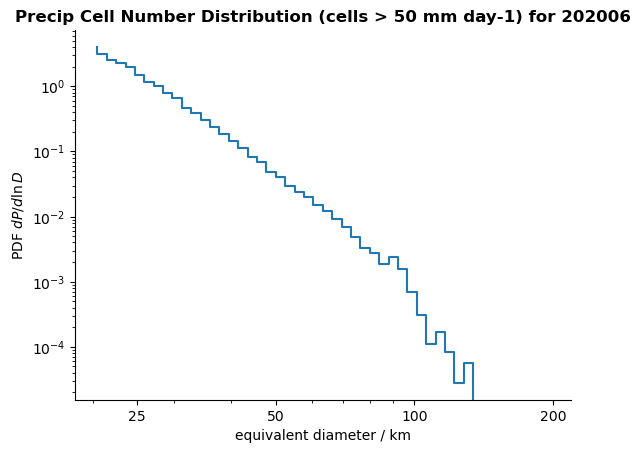

In [15]:

plt.step(1e-3*mdia, PDF )
sns.despine()

plt.ylabel('PDF $dP / d\ln D$')
plt.xlabel('equivalent diameter / km')
plt.title(f'Precip Cell Number Distribution (cells > 50 mm day-1) for {date}', fontweight = 'bold') 
plt.xscale('log')
plt.yscale('log')
plt.xticks( [25, 50, 100, 200], [25, 50, 100, 200]);


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_812581/892454591.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('PDF $dP / d\ln D$')


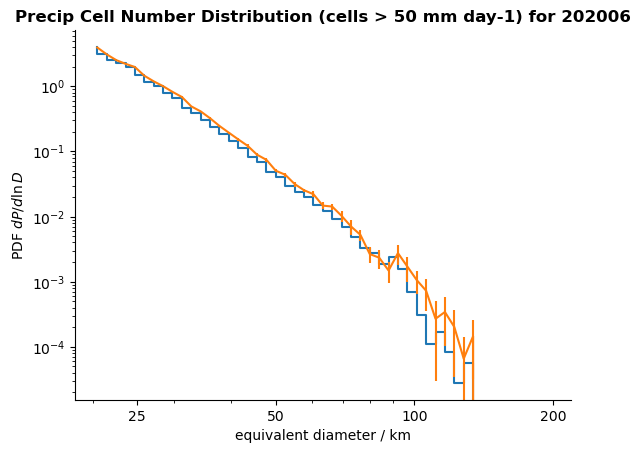

In [16]:

mPDF = PDF_daily.mean('day')
semPDF = 2*PDF_daily.std('day') / np.sqrt(30)

plt.step(1e-3*mdia, PDF )
plt.errorbar(mdia*1e-3, mPDF, yerr = semPDF ) 
sns.despine()
plt.xlabel('equivalent diameter / km')
plt.ylabel('PDF $dP / d\ln D$')
plt.title(f'Precip Cell Number Distribution (cells > 50 mm day-1) for {date}', fontweight = 'bold') 
plt.xscale('log')
plt.yscale('log')
plt.xticks( [25, 50, 100, 200], [25, 50, 100, 200]);


## Output

In [17]:
main_dir = "/work/bb1376/user/fabian/data/oxford-hackathon"
outdir = f"/{main_dir}/{model}/{experiment}/statistics"

PDF_daily.attrs['name'] = 'PDF_CSD'
PDF_daily.attrs['long_name'] = 'PDF of global cell size distribution'
PDF_daily.attrs['unit'] = '-'

outfile = f'{outdir}/global_csd_{subname}_{date}.nc'

In [19]:
out = xr.Dataset()
out['PDF_CSD'] = PDF_daily
out.to_netcdf( outfile )
#PDF_daily.to_netcdf( outfile )